In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import math
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import VarianceThreshold


import dask.dataframe as dd
from dask.distributed import Client
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import StandardScaler, DummyEncoder
from dask_ml.xgboost import XGBRegressor
from dask_ml.linear_model import LinearRegression


import joblib

In [2]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
def print_nulls(ddf):
    out = ddf.isnull().sum()*100/ddf.isnull().isnull().count()
    
    return print_full(out.compute())

In [3]:
def plot_hist_boxplot(df):
    '''
    Accepts only numerical columns;
    use a maks.
    '''
    dim = df.shape[1]
    plt.figure(figsize=(20, dim*5))
    
    # iterate through the columns
    for i, column in enumerate(df.columns):
        
        # plot a histogram
        plt.subplot(dim, 2, (i+1)*2-1)
        plt.hist(df[column])
        plt.ylabel(column)
        
        # plot a boxplot
        plt.subplot(dim, 2, (i+1)*2)
        plt.boxplot(df[column], whis=[2.5, 97.5]) # boxplot will show outliers beyond the inner 95th percentile
    plt.show()

In [28]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36749 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.71 GB


In [4]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

query1 = '''
SELECT
  *
FROM
  houseprices
'''

df = pd.read_sql_query(query1, con=engine)
engine.dispose()

# Transfer the resulting pandas dataframe into dask
df = dd.from_pandas(df, npartitions=4)

In [5]:
# See how many null values there are
print_nulls(df)

id                0.000000
mssubclass        0.000000
mszoning          0.000000
lotfrontage      17.739726
lotarea           0.000000
street            0.000000
alley            93.767123
lotshape          0.000000
landcontour       0.000000
utilities         0.000000
lotconfig         0.000000
landslope         0.000000
neighborhood      0.000000
condition1        0.000000
condition2        0.000000
bldgtype          0.000000
housestyle        0.000000
overallqual       0.000000
overallcond       0.000000
yearbuilt         0.000000
yearremodadd      0.000000
roofstyle         0.000000
roofmatl          0.000000
exterior1st       0.000000
exterior2nd       0.000000
masvnrtype        0.547945
masvnrarea        0.547945
exterqual         0.000000
extercond         0.000000
foundation        0.000000
bsmtqual          2.534247
bsmtcond          2.534247
bsmtexposure      2.602740
bsmtfintype1      2.534247
bsmtfinsf1        0.000000
bsmtfintype2      2.602740
bsmtfinsf2        0.000000
b

In [6]:
# Define a function to clean the dataframe

def clean(df):
    '''
    I'd like to figure out a better way to make this delayed.
    For now I am going to use several helper functions and
    map_partitions/apply.
    '''
    
    # Define meta for use across functions
    meta = dd.utils.make_meta(df)
    
    # Apply helper functions
    for col in ['alley', 'fence', 'poolqc', 'fireplacequ'
                , 'bsmtqual','bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2'
                   , 'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'masvnrtype']:
        df = df.map_partitions(not_included, col=col, meta=meta)
        
    df['masvnrarea'] = df['masvnrarea'].fillna(0)
    
    # Use fancy indexing to consolidate the mssubclass variable
    df[df['mssubclass'] == 40][df['yearbuilt'] >= 1946]['mssubclass'] = 20

    df[df['mssubclass'] == 40][df['yearbuilt'] <= 1945]['mssubclass'] = 30

    df[df['mssubclass'] == 45]['mssubclass'] = 50
    
    # Create new meta because type of mssubclass has changed
    df['mssubclass'] = df['mssubclass'].astype('object')
    meta = dd.utils.make_meta(df)

    # Translate the subclass codes to their categorical features
    df = df.map_partitions(replace, meta=meta)
    
    # consolidate outdoor space variables
    df['outdoor_space'] = df['wooddecksf'] + df['openporchsf'] + df['enclosedporch'] + df['threessnporch'] + df['screenporch']

    # There are many possible ways to group the square footage. Here I will begin with two groupings and see
    # how they perform in modeling.
    df['interior_square_feet'] = df['totalbsmtsf'] + df['grlivarea']

    # Combine the bathrooms variables
    df['total_bathrooms'] = df['bsmtfullbath'] + df['bsmthalfbath']/2 + df['fullbath'] + df['halfbath']/2

    # convert year built to age
    df['age'] = 2010 - df['yearbuilt']
    
    # Generate a new meta to match new columns
    meta = dd.utils.make_meta(df)
    
    # Handle outliers and transform some features
    log_list = ['saleprice', 'lotarea']

    log_plus_list = ['masvnrarea', 'outdoor_space']

    both_bounds = ['interior_square_feet', 'totrmsabvgrd']

    upper_bound = ['age', 'total_bathrooms', 'garagearea']
    
    for col in log_list:
        df[col] = np.log(df[col])
    
    for col in log_plus_list:
        df[col] = np.log(df[col] + 1)
    
    for col in both_bounds:
        df = df.map_partitions(wins_both, col=col, meta=meta)

    for col in upper_bound:
        df = df.map_partitions(wins_upper, col=col, meta=meta)

    
    # Drop variables that are not needed
    df = df.drop(['id', 'totalbsmtsf', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'grlivarea', 'firstflrsf', 'secondflrsf'
             , 'lowqualfinsf',  'wooddecksf', 'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch'
             , 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'garageyrblt', 'miscfeature', 'miscval'
                  , 'lotfrontage', 'yearbuilt', 'garagecars', 'bedroomabvgr' ], axis=1)
    
    
    df = df.dropna()
    
    # Return the modified frame
    return df

def wins_upper(df, col) -> pd.DataFrame:
    df[col] = winsorize(df[col], (0, 0.025))
    return df
    
def wins_both(df, col) -> pd.DataFrame:
    df[col] = winsorize(df[col], (0.025, 0.025))
    return df
    
    
# Define helper functions
def not_included(df, col) -> pd.DataFrame:
    '''
    Several features have null values when the feature is not included
    '''
    df[col] = df[col].fillna('feature_not_included')
    return df

def replace(df) -> pd.DataFrame:
    subclass_map = { 20 : '1_story_1946_forward'
        , 30 : '1_story_1945_backward'
        , 50 : '1.5_story'
        , 60 : '2_story_1946_forward'
        , 70 : '2_story_1945_backward'
        , 75 : '2.5_story'
        , 80 : 'split_level'
        , 85 : 'split_foyer'
        , 90 : 'duplex'
       , 120 : '1_story_planned'
       , 160 : '2_story_planned_'
       , 180 : 'planned_multilevel'
       , 190 : '2_family_conversion'
               }
    return df.replace({'mssubclass' : subclass_map})

In [7]:
# Apply the cleaning function
df = clean(df)

In [8]:
# Check to see that nulls were filled
print_nulls(df)

mssubclass              0.0
mszoning                0.0
lotarea                 0.0
street                  0.0
alley                   0.0
lotshape                0.0
landcontour             0.0
utilities               0.0
lotconfig               0.0
landslope               0.0
neighborhood            0.0
condition1              0.0
condition2              0.0
bldgtype                0.0
housestyle              0.0
overallqual             0.0
overallcond             0.0
yearremodadd            0.0
roofstyle               0.0
roofmatl                0.0
exterior1st             0.0
exterior2nd             0.0
masvnrtype              0.0
masvnrarea              0.0
exterqual               0.0
extercond               0.0
foundation              0.0
bsmtqual                0.0
bsmtcond                0.0
bsmtexposure            0.0
bsmtfintype1            0.0
bsmtfintype2            0.0
heating                 0.0
heatingqc               0.0
centralair              0.0
electrical          

In [9]:
df.shape[0].compute()

1459

In [10]:
# Now that the data frame is more cleaned up persist it
#df = df.persist()

## EDA

Here I will make apply some basic visualizations.

In [11]:
# create masks for the columns by type
conts = df.select_dtypes(include='number').columns
cats = df.select_dtypes(include='object').columns

<AxesSubplot:>

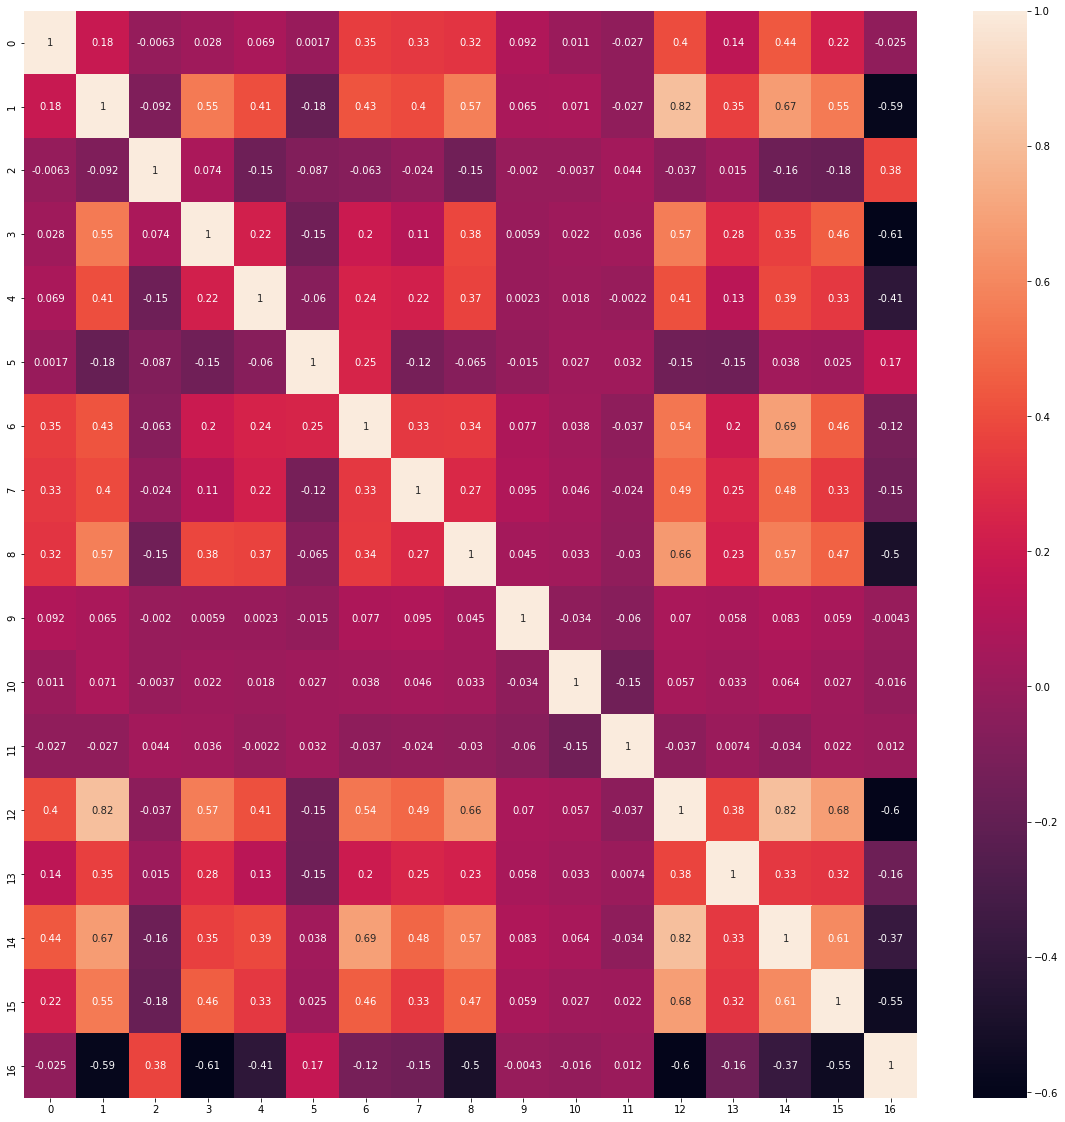

In [12]:
# Plot a heatmap of correlation
corr_map = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_map, annot=True)

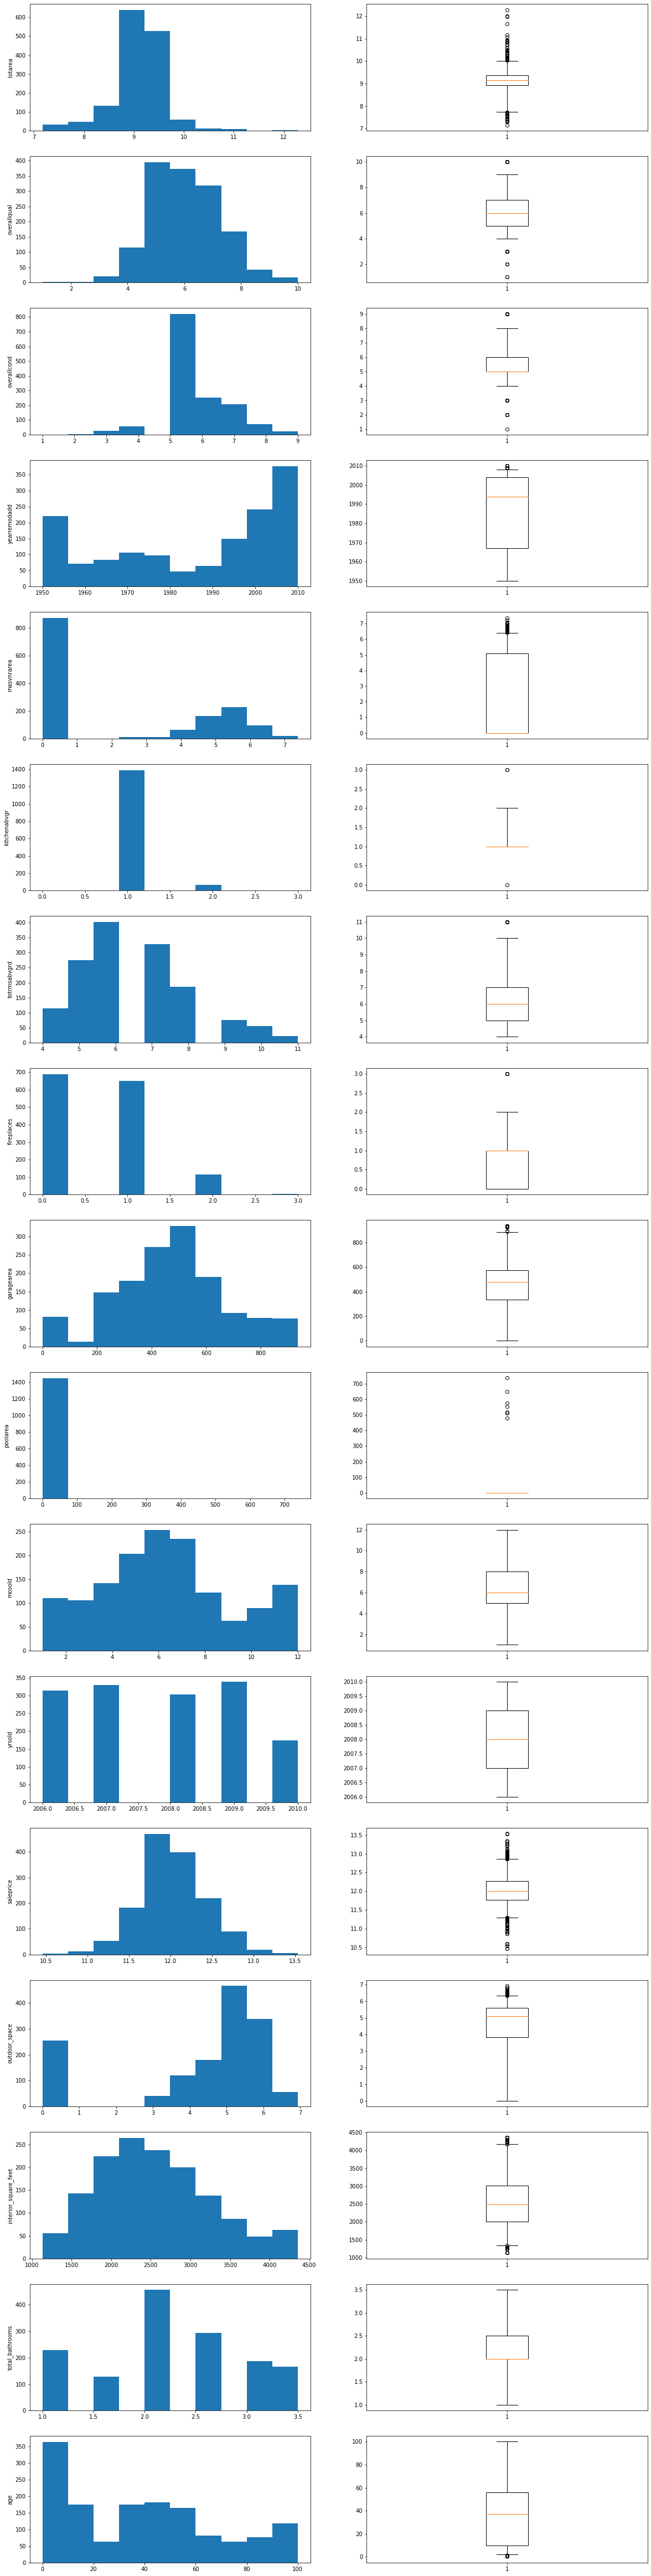

In [13]:
plot_hist_boxplot(df.select_dtypes(include='number'))

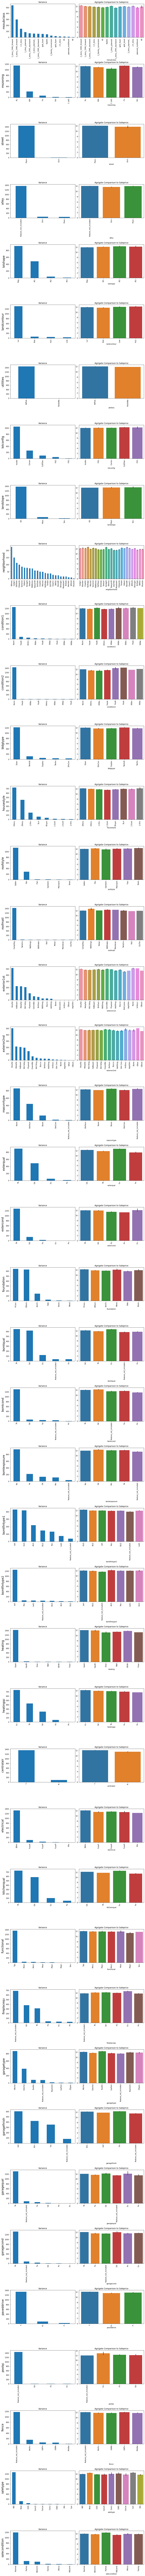

In [15]:
plt.figure(figsize=(12, len(cats)*5))
for i, feature in enumerate(cats):
    plt.subplot(len(cats), 2, (i+1)*2-1)
    df[feature].value_counts().compute().plot(kind='bar')
    plt.ylabel(feature, size='xx-large')
    plt.title('Variance')
    plt.xlabel('')
    plt.xticks(rotation=90)
    
    
    plt.subplot(len(cats), 2, (i+1)*2)
    sns.barplot(x=df[feature].compute(), y=df['saleprice'])
    plt.ylabel('')
    plt.title('Agrigate Comparison to Saleprice')
    plt.xticks(rotation=90)
plt.tight_layout(pad=0.3)
plt.show()

## Feature Engineering
Since I've already covered this dataset I already have a good idea of what features are most important and how to transform them. Some of this was already done during the cleaning phase in the clean function such as log transformations.

In [12]:
X = df.drop('saleprice', axis = 1)
y = df['saleprice']

# Encode categorical variables
X = X.categorize().compute()
de = DummyEncoder()
X = de.fit_transform(X)



In [14]:
# Drop the dominant class or the most neutral class for each of the categorical variables

X = X.drop(['mssubclass_1_story_1946_forward'
         , 'mszoning_RL'
         , 'street_Pave'
         , 'alley_feature_not_included'
         , 'lotshape_Reg'
         , 'landcontour_Lvl'
         , 'utilities_AllPub'
         , 'lotconfig_Inside'
         , 'landslope_Gtl'
         , 'neighborhood_NAmes'
         , 'neighborhood_NPkVill'
         , 'condition1_Norm'
         , 'condition2_Norm'
         , 'condition2_PosA'
         , 'bldgtype_1Fam'
         , 'housestyle_1Story'
         , 'roofstyle_Gable'
         , 'roofmatl_CompShg'
         , 'exterior1st_VinylSd'
         , 'exterior2nd_VinylSd'
         , 'masvnrtype_None'
         , 'exterqual_TA'
         , 'extercond_TA'
         , 'foundation_PConc'
         , 'bsmtqual_TA'
         , 'bsmtexposure_Av'
         , 'bsmtfintype1_Unf'
         , 'bsmtfintype2_Unf'
         , 'heating_GasA'
         , 'heatingqc_TA'
         , 'centralair_N'
         , 'electrical_SBrkr'
         , 'kitchenqual_TA'
         , 'functional_Typ'
         , 'fireplacequ_TA'
         , 'garagetype_Attchd'
         , 'garagefinish_Unf'
         , 'garagequal_TA'
         , 'garagecond_TA'
         , 'paveddrive_Y'
         , 'poolqc_feature_not_included'
         , 'fence_feature_not_included'
         , 'saletype_WD'
         , 'salecondition_Normal'], axis=1)

In [15]:
# Remove features with low variance
threshold = VarianceThreshold(threshold=.1)
threshold.fit(X)
mask = threshold.get_support()
X = X.loc[:, mask].copy()

In [16]:
# Scale the features
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [20]:
# Split the data for training
X_train, X_test, y_train, y_test = train_test_split(X, y.compute(), test_size=.25, random_state=1312)


In [83]:
from xgboost import XGBRegressor as XGB

In [40]:
params = {'learning_rate' : .03
          , 'gamma' : 0
          , 'n_estimators' : 300
          , 'max_depth' : 4
          , 'booster' : 'gblinear'
          , 'random_state' : 1312
         } 

xgb = XGB(client=client, params=params)

In [41]:
xgb

XGBRegressor(client=<Client: 'tcp://127.0.0.1:36749' processes=4 threads=4, memory=16.71 GB>,
             params={'booster': 'gblinear', 'gamma': 0, 'learning_rate': 0.03,
                     'max_depth': 4, 'n_estimators': 300,
                     'random_state': 1312})

In [43]:
xgb.fit(X_train, y_train)

[23:11:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(client=<Client: 'tcp://127.0.0.1:36749' processes=4 threads=4, memory=16.71 GB>,
             params={'booster': 'gblinear', 'gamma': 0, 'learning_rate': 0.03,
                     'max_depth': 4, 'n_estimators': 300,
                     'random_state': 1312})

In [44]:
xgb.score(X_test, y_test)

0.895849745973749

In [70]:
# Use Grid Search to find the best paramaters
params = {'learning_rate' : np.arange(.1, 1.1, .1)
          , 'gamma' : np.arange(0, .3, .05)
          , 'n_estimators' : np.arange(50, 551, 50)
          , 'booster' : ['gblinear', 'gbtree']
    
    
}

xgb = XGB()
cv = GridSearchCV(xgb, params)

with joblib.parallel_backend('dask'):
    cv.fit(X, y.compute())
    

[00:24:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [82]:
cv.best_estimator_

XGBRegressor(gamma=0.0, n_estimators=150)

In [72]:
cv.best_params_

{'booster': 'gbtree', 'gamma': 0.0, 'learning_rate': 0.1, 'n_estimators': 150}

In [78]:
xgb = XGB(params=cv.best_params_)

In [79]:
xgb.fit(X_train, y_train).score(X_test, y_test)

[00:28:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.895849745973749

Using Dask significanly sped up Grid Search corss validation. Even if it did not improve the accuracy.